# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from datetime import timedelta
from time import time

%matplotlib inline

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.pkl'
testing_file = 'test.pkl'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
# First, let's check what traffic classes exist to images from training file
# And we know there are 0 - 42 classes of traffic signs exist in training
np.bincount(y_train).nonzero()[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42])

In [3]:
# Next, let's check what traffic classes exist to images from testing file
# Also we know there are 0 - 42 classes of traffic signs exist in testing
np.bincount(y_test).nonzero()[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42])

In [4]:
# Briefly check the traffic class distribution in training
np.bincount(y_train)

array([ 210, 2220, 2250, 1410, 1980, 1860,  420, 1440, 1410, 1470, 2010,
       1320, 2100, 2160,  780,  630,  420, 1110, 1200,  210,  360,  330,
        390,  510,  270, 1500,  600,  240,  540,  270,  450,  780,  240,
        689,  420, 1200,  390,  210, 2070,  300,  360,  240,  240])

In [5]:
# Briefly check the traffic class distribution in testing
np.bincount(y_test)

array([ 60, 720, 750, 450, 660, 630, 150, 450, 450, 480, 660, 420, 690,
       720, 270, 210, 150, 360, 390,  60,  90,  90, 120, 150,  90, 480,
       180,  60, 150,  90, 150, 270,  60, 210, 120, 390, 120,  60, 690,
        90,  90,  60,  90])

### Have seen that traffic sign class distributions are closely similar between training and testing, but let's visualize! 

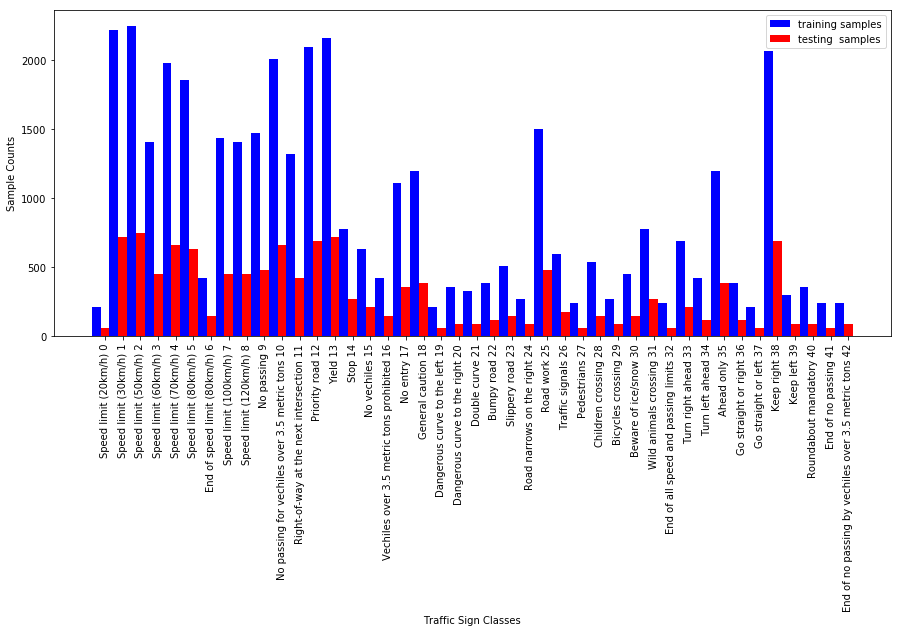

In [6]:
sign_names = pd.read_csv('signnames.csv')

classes = np.bincount(y_train).nonzero()[0]

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
x = classes
yTrain = np.bincount(y_train)
yTest  = np.bincount(y_test)

bar_train = ax.bar(x, yTrain, width=0.5, color='b')
bar_test  = ax.bar(x+0.5, yTest,  width=0.5, color='r')
ax.set_xlabel('Traffic Sign Classes')
ax.set_ylabel('Sample Counts')
ax.set_xticks(x+0.5)
ax.set_xticklabels(sign_names.SignName.astype(str) + ' ' + sign_names.ClassId.astype(str), rotation = 90)
ax.legend((bar_train[0], bar_test[0]), ('training samples', 'testing  samples'))
plt.show()

### Key properties of data distribution that are obversed:
+  ####  Both training and testing image samples are very unbalanced distribution across different traffic sign classes
+  ####  But the unbalanced distribution across different traffic sign classes between traing and testing are similar (fortunately)
+  ####  All classes of traffic signs have got some sample images
   

In [7]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = y_train.shape[0]

# TODO: number of testing examples
n_test = y_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
# check y_test has the same traffic classes as y_train
n_classes = 0
if np.array_equal(np.bincount(y_train).nonzero()[0], np.bincount(y_test).nonzero()[0]):
    n_classes = np.bincount(y_test).nonzero()[0].size

min_train_cls = np.argmin(yTrain)
max_train_cls = np.argmax(yTrain)
min_test_cls = np.argmin(yTest)
max_test_cls = np.argmax(yTest)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("----------------------")
print("Training set: minimum class = {}, count = {}".format(min_train_cls, yTrain[min_train_cls]))
print("Training set: maximum class = {}, count = {}".format(max_train_cls, yTrain[max_train_cls]))
print("Testing  set: minimum class = {}, count = {}".format(min_test_cls, yTest[min_test_cls]))
print("Testing  set: maximum class = {}, count = {}".format(max_test_cls, yTest[max_test_cls]))

('Number of training examples =', 39209)
('Number of testing examples =', 12630)
('Image data shape =', (32, 32, 3))
('Number of classes =', 43)
----------------------
Training set: minimum class = 0, count = 210
Training set: maximum class = 2, count = 2250
Testing  set: minimum class = 0, count = 60
Testing  set: maximum class = 2, count = 750


In [8]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# Now we know that each class of training or testing traffic signs has got some images,
# to plot all images to each class is not feasible as in this notebook, so instead I'll
# plot random-k images from each traffic sign class, and set k=1 below! 

# Helper function to plot images side-by-side with title
def plot_gallery(images, titles, h, w, n_row=3, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(2.0 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    llen = 21
    for i in range(min(n_row * n_col, len(images))):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        title_i = titles[i]
        if len(title_i) >= llen:
            title_i = titles[i][:llen] + '\n' + titles[i][llen:]
        plt.title(title_i, size=12)
        plt.xticks(())
        plt.yticks(())

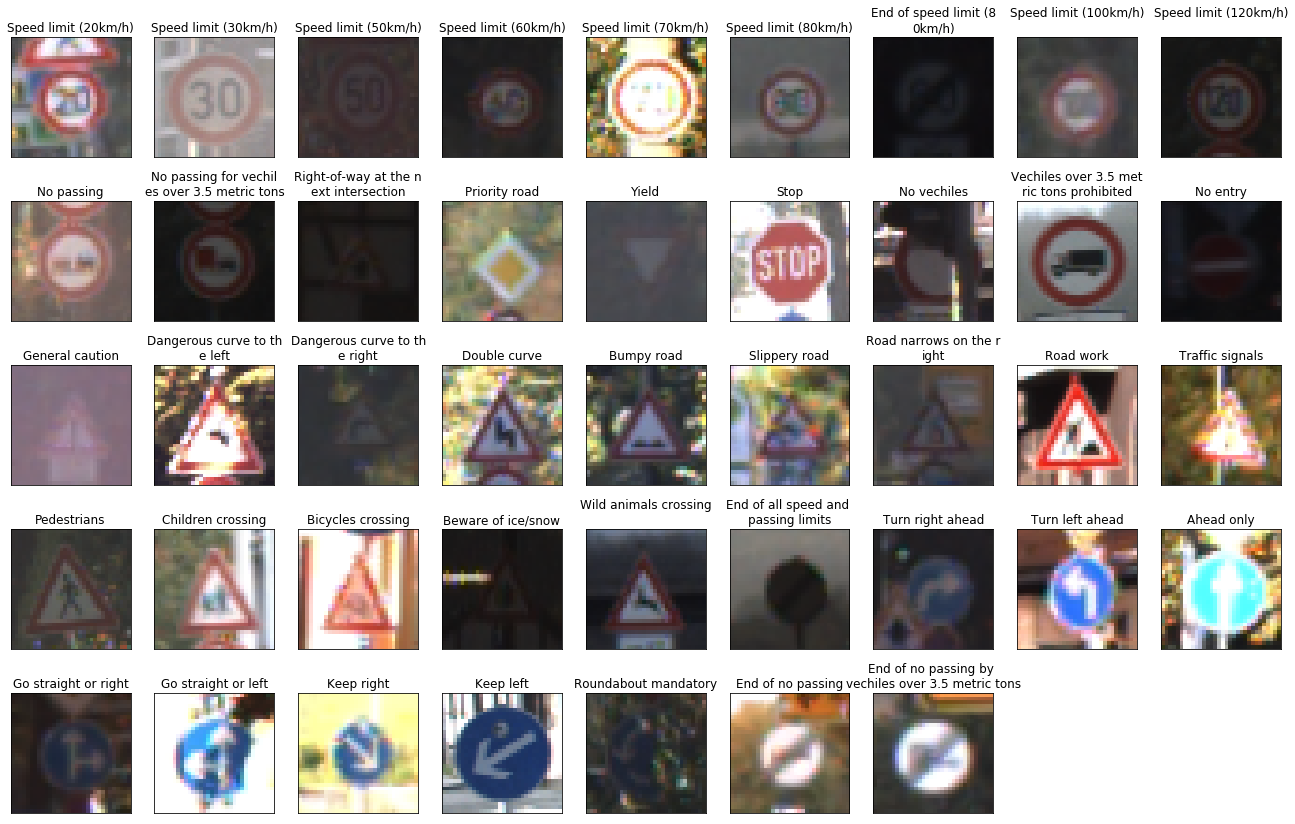

In [9]:
# It is not feasible to plot all traffic signs to each Class in either train or test set,
# so only plot the 1st sign of a Class from training images as visualization

# find 1st occurring Indices of unique traffic signs
u, indices = np.unique(y_train, return_index=True)

# u is array of unique ClassIds in ascending order, align with sign_names['SignName']
plot_gallery(X_train[indices], sign_names['SignName'], 32, 32, 5, 9)


### German Traffic Sign Examples of all 0 - 42 Classes from training set (1 per class, left to right, top to down)

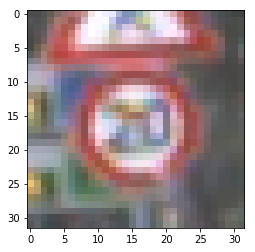

In [10]:
# plot one traffic sign for example
plt.imshow(X_train[0])

### _Now we know traffic sign images dimension is 32 x 32 with 3 input color channels_

In [11]:
X_train[0].shape

(32, 32, 3)

#### As we see above first batch samples from each class traffic sign, some images are really difficult (dark, low contrast, reflection, etc.). These images would impact performance of classifier to be built, if they were not image enhanced. But in this project, I will not try a programmatic way to enhance a image according to its quality of recognition (by human), that remains an experiment to improvement, but we need to deploy a same enhancement criteria to test data set once it was used on training images.



----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [12]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# Choose not to do grayscale on original images here, due to:
# - Image dimension is 32x32x3, not much concern in converting to 32x32x1 in saving computation
# - It is harder to normalize a grayscaled image, since grayed_pixel_val = kind_of_mean(R,G,B),
#   its pixel value distribution is no more uniform & min/max is different from image to image 
# - Like to let CNN learn the color scheme of traffic sign to boost result consider that there
#   are no different signs of a same class be different only in colors (where grayscale helps)

# Then TWO primary preprocesses are implemented here:

# 1. Image normaliztion as (R/G/B-128.)/128, to achieve 0 mean & normal distribution (-1., 1.)

X_train_norm = (X_train - 128.)/128
X_test_norm  = (X_test  - 128.)/128


# 2. Class Label OneHot Encoding

y_test_ohot  = np.eye(n_classes)[y_test]


# N.B. Final performance report will be using:
#      X_test_norm,   y_test_ohot
#                  vs.
#           X_test,   y_test

# N.B. Not do OneHot on global training labels as below now
#      y_train_ohot = np.eye(n_classes)[y_train]
#
# Instead OneHot is done on training & validation set from train_test_split later


#### Split training image set to train and validation, so to keep test set untouched from training process
#### From traffic signs distribution plots (across 43 classes) above, we see two patterns:
+ It is not uniform distribution across 43 classes
+ Test images distribution is similar to train images (so no need to apply different ratio as in train set)
+ train_test_split need to use stratify=y_label to make sure particular labels ratio is maintained in both training set and validation set
+ not convert to grayscale, since its normalization will be a question, i.e. if use max/min of local image, then normalization is different cross images, if use max=255, min=0, then we changed distribution post normalization, since grayscaled pixels of mean(R,G,B) is not going to be uniform dist, even assume three R/G/B channels is unfirm distributed individually.
+ use normalization on color images: (img-128.)/128
+ make class labels one-hot encoded 2-D np.array (num_samples x num_classes), not use tf.one_hot for now
    - y_train_onehot = np.eye(n_classes)[y_train]
    - y_test_onehot  = np.eye(n_classes)[y_test]

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

+ #### Mostly answered in cell above, mainly are:
    - ##### Choose to use 3 channels color Images to avoid normalization discrepency
    - ##### Implement a Zero-Mean Normalization to color pixels on all 3 channels, as (Img - 128.) / 128
    - ##### Implement One-Hot encoding to all Y class Labels in Training, Validation and Testing set.


Prior split Training set: minimum class = 0, count = 210
Prior split Training set: maximum class = 2, count = 2250


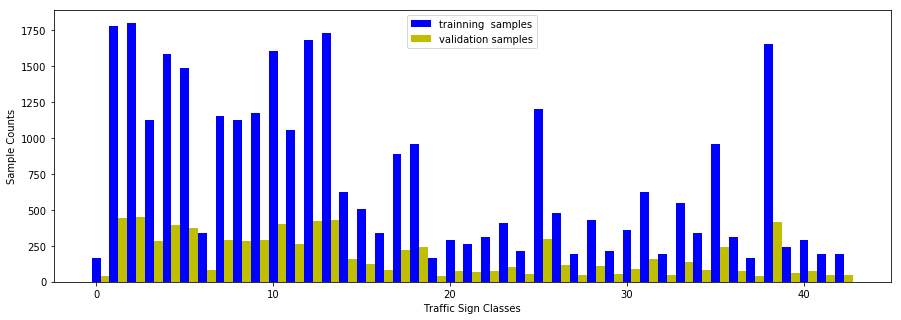

Post split  Training  set: minimum class = 0, count = 168
Post split  Training  set: maximum class = 2, count = 1800
Post split Validation set: minimum class = 0, count = 42
Post split Validation set: maximum class = 2, count = 450


In [13]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.


print("Prior split Training set: minimum class = {}, count = {}".format(min_train_cls, yTrain[min_train_cls]))
print("Prior split Training set: maximum class = {}, count = {}".format(max_train_cls, yTrain[max_train_cls]))


# Knowing that minimum sample count of a class is 210 & max sample count of a class is 2250 in training samples
# We must not split training & validation set by random percentage! Must use stratify instead to retain ratios!
# Randomly spare ~20% images cross Class for validation, leave testing set untouched until final report.

X_t, X_v, y_t, y_v = train_test_split(X_train_norm, y_train, test_size=0.2, random_state=101, stratify=y_train)


# To confirm splitted train_set (X_t, y_t) & validation_set (X_v, y_v) both have all the Classes
#    and retain a similar cross-class samples distribution as prior, let's do visualize :)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
x = classes
yT = np.bincount(y_t)
yV  = np.bincount(y_v)

bar_t = ax.bar(x, yT, width=0.5, color='b')
bar_v  = ax.bar(x+0.5, yV,  width=0.5, color='y')
ax.set_xlabel('Traffic Sign Classes')
ax.set_ylabel('Sample Counts')
#ax.set_xticks(x+0.5)
#ax.set_xticklabels(sign_names.SignName.astype(str) + ' ' + sign_names.ClassId.astype(str), rotation = 90)
ax.legend((bar_t[0], bar_v[0]), ('trainning  samples', 'validation samples'))
plt.show()

min_t_cls = np.argmin(yT)
max_t_cls = np.argmax(yT)
min_v_cls = np.argmin(yV)
max_v_cls = np.argmax(yV)

print("Post split  Training  set: minimum class = {}, count = {}".format(min_t_cls, yT[min_t_cls]))
print("Post split  Training  set: maximum class = {}, count = {}".format(max_t_cls, yT[max_t_cls]))
print("Post split Validation set: minimum class = {}, count = {}".format(min_v_cls, yV[min_v_cls]))
print("Post split Validation set: maximum class = {}, count = {}".format(max_v_cls, yV[max_v_cls]))


# Now do OneHot on training and validation labels
y_to = np.eye(n_classes)[y_t]
y_vo = np.eye(n_classes)[y_v]

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

+ #### Most answers lie in implementation above, here comes summary
+ #### I intended to keep testing dataset (from test.p) unused during training to avoid model been affected by final testing data, to:
    - ##### maintain an authentic, accoutable, reliable and fair final testing result on testing dataset
    - ##### follow a common practice as testing dataset are often unavailable beforehand, so not expect to use them
+ #### I plotted sample distributions cross classes on both traioning dataset and testing dataset, fortunately their shape are very similar
+ #### I split original training dataset (from train.p) to TWO part: training set and validation set, using train_test_split( ):
    - ##### by maintaining samples distributions w/. stratify split, this is important to avoid underfit a certain class vs. overfit another class!
    - ##### run model training only on training set, and run model validation on validation set to discover variance
    - ##### by design, we could run cross validation with limited samples, but given the time consuming in training the deep neuron network, I will skip cross validations (e.g. generalize model further w/. KFold) for now, may revisit if a final testing score (Loss) is not good.
    - ##### Have cross-validation is better, but training time prevent running many times. So leave CV in the future.
+ #### Not keen to generate additional (spatial transform, jittering) data to start, will only do if performance suffer:
    - ##### Traing, Validation and Testing dataset are all similar in sample distribution
    - ##### Unnecessary to change sample distributions in generating extra samples, should not change if we do


In [14]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Network architecture (Preliminary choice: 2 ConvNets + 2 FullConnected NNets. Main constraints: Computational Power!)
# Shape of tensors passing along the graph is annotated in (); basic layers formation is annotated in []
# Images (,32,32,3)=> CNN1[3x5x5x16] =(,16,16,16)=> CNN2[16x5x5x32] =(,8,8,32)=> FC1[2048x128] ==> FC2[128x43] => Logits
# N.B.
#   - FC2 nodo ReLU 
#   - FC1 todo dropout (optional)

# Global Architecture Parameters Definition:

# Use 5x5 kernel at both Convolutional Layers
ck_size = 5

# Depth (output channels) of CNN1 and CNN2 
c1depth = 16
c2depth = 32

# Input size to FC1 is known 2048 (flat of 8x8x32)
# Output  from  FC2 is known  43  (num of classes)

# Size between fully connected layers: FC1 and FC2
fc_size = 128

# Definitions of Images
img_size = 32
imgdepth = 3
imgshape = (img_size, img_size, imgdepth)

### TensorFlow Graph Definition
#### Add following parts to construct TensorFlow Graph to the architecture defined:
+ Placeholder variables to both Input Images and Images True Labels for output comparison
+ Variables used and to be optimized: weight and bias to each CNN or FC layers
+ Construct each network layer & connect them to a complete graph
+ Come up loss function to evaluate training and guide an optimizer
+ Add an optimizer in updating model variables to drive down loss

#### Helper Methods

In [15]:
# Helper functions

def init_weight(shape):
    # be sure to use small stddev, as model starts with unsure 
    return tf.Variable(tf.truncated_normal(shape, stddev=0.001))

def init_bias(size):
    return tf.Variable(tf.constant(0.001, shape=[size]))


# N.B. first dimension of input tensor is arbitrary, it is the number of samples determined at feed
# Parameters -
#      input : input tensor
#  out_depth : output depth or channels
#     k_size : ConvNet kernel patch size, e.g. 5 for 5x5
#    maxpool : use maxpooling to down sampling output ?
#       relu : use ReLU (Rectified Linear Unit) activation ?
def newCN(input, out_depth, k_size = 5, maxpool = True, relu = True):
    
    # ConvNet patch weight shapes, according to TensorFlow API
    in_depth = input.get_shape()[-1:].num_elements()
    wshape = [k_size, k_size, in_depth, out_depth]

    # Build ConvNet patch weight with initial value
    weight = init_weight(wshape)

    # Build ConvNet patch biases with initial value
    bias = init_bias(out_depth)

    # Create the TensorFlow operation for convolution.
    # N.B. the strides are set to 1 in all dimensions.
    # This stride produce tensor w. same Width,Height.
    # We use max_pool to down-sample output if needed.
    conv = tf.nn.conv2d(input = input,
                        filter = weight,
                        strides = [1, 1, 1, 1],
                        padding = 'SAME')

    # Add bias to output channels
    conv += bias

    if maxpool:
        # only 2x2 max-pooling for now
        conv = tf.nn.max_pool( value = conv,
                               ksize = [1, 2, 2, 1],
                               strides = [1, 2, 2, 1],
                               padding = 'SAME')

    if relu:
        # only ReLU to add non-linear activation for now
        conv = tf.nn.relu(conv)

    # return the result conv layer and parameters
    # return conv, weight, bias
    return conv
    
    
# N.B. first dimension of input tensor is arbitrary, it is the number of samples determined at feed
# Parameters -
#      input : input tensor, do flatten in function if it is not already
#     out_nn : output number of neurons
#       relu : use ReLU (Rectified Linear Unit) activation ? (it should be False at last FC layer)
#    dropout : use dropout as regularization to avoid overfit ?
# N.B. practice:
#    - Output FC layer: no ReLU, no dropout
#    - Hidden FC layer: w/ ReLU, dropout optional for overfit tuning 
def newFC(input, out_nn, relu = False, dropout = False):
    
    input_features = input.get_shape()[1:].num_elements()
    
    if input.get_shape()[1:] != input.get_shape()[-1:]:
        # reshape input to flatten
        flat_input = tf.reshape(input, [-1, input_features])
    else:
        flat_input = input

    weight = init_weight([input_features, out_nn])
    bias = init_bias(out_nn)
    
    # Y = X*W + b
    fc = tf.matmul(flat_input, weight) + bias
    
    if relu:
        fc = tf.nn.relu(fc)

    if dropout:
        # fc = tf.nn.dropout(fc, keep_prob = 0.5)
        
        # Do NOT use hard coded keep_prob
        # It MUST be feed differently: training (0.5) -OR- valiation (1.0) !!
        # keep_prob = tf.placeholder(tf.float32)

        fc = tf.nn.dropout(fc, keep_prob)

    return fc

#### Placeholder Variables

In [16]:
# Placeholder for input images tensor
X_image = tf.placeholder(tf.float32, shape=[None, img_size, img_size, imgdepth])

# Placeholder for true class labels tensor
y_class = tf.placeholder(tf.float32, shape=[None, n_classes])

# True Class IDs of OneHot tensors
# N.B. we have global true class labels y_t, y_v, y_test,
#  but those are not lined up with a tensor, so use this:
y_true_class = tf.argmax(y_class, dimension = 1)

keep_prob = tf.placeholder(tf.float32)

#### Connect Network Graph

In [17]:
# CNN1: 5x5 kernel, 3 input color channels, 16 output filters; use 2x2 max_pooling and ReLU
cnn1 = newCN(input = X_image, out_depth = c1depth, k_size = 5, maxpool = True, relu = True)

# CNN2: 5x5 kernel, 16 input channels, 32 output channels; use 2x2 max_pooling and ReLU
cnn2 = newCN(input = cnn1, out_depth = c2depth, k_size = 5, maxpool = True, relu = True)

# FC1 - hidden layer, [-1, 8, 8, 32] :=> FC1 :=> [-1, 128]
fc1 = newFC(input = cnn2, out_nn = fc_size, relu = True, dropout = True)

# FC2 - output layer, [-1, 128] :=> FC2 :=> [-1, 43]
fc2 = newFC(input = fc1, out_nn = n_classes, relu = False)


### TensorFlow Graph Execution

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

Finding the optimal architecture of a ConvNet for a given task remains mainly empirical, I'd like to investigate and research further in area such as GridCV search in network architecture.

### I choose Convolutional Neuron Networks to solve this problem, and the network architecture is:
+ #### 2 Covolutional Layers, each does
    - ##### 5x5 Kernel
    - ##### [1,2,2,1] Max_pooling
    - ##### ReLU
+ #### 2 Full Connected Layers
    - ##### FC1 does: ReLU, Dropout
    - ##### FC2: No ReLU No Dropout

### Computational Graph looks like:

#### Image_Tensor (, 32, 32, 3) => ConvNet_1 [3 x 5 x 5 x 16] = Tensor(, 16, 16, 16) => ConvNet_2 [16 x 5 x 5 x 32] = Tensor(, 8, 8, 32) = Tensor_flatten(, 2048) ==> FullConnect_1 [2048 x 128] == Tensor(, 128) ==> FullConnect_2 [128, 43] => Logits_Tensor(, 43) 

#### _TODO_
+ ##### Add TensorBoard plots to demonstrate graph architecture

### Training Premitives: Loss function, Valuation Matrix and Performance Measures

In [18]:
### Training Evaluation Primitives

learn_rate = 0.001

# Logits is One-Hot output of FC2
logits = fc2

# Prediction in softmax probabilities
y_pred = tf.nn.softmax(logits)

# Prediction in Class IDs
y_pred_class = tf.argmax(y_pred, dimension = 1)

# Come up Loss function of supervised classification
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = y_class)

# Loss is the batch -or- global mean of cross_entropy
# It will be used by optimizer to minimize @ training 
loss = tf.reduce_mean(cross_entropy)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = learn_rate).minimize(loss)

# Good prediction tensor from TWO equal length comparison tensors,
# e.g. batch -or- global
good_pred = tf.equal(y_pred_class, y_true_class)

# Predictor Accuracy, pertain to the length of the tensor,
# e.g. batch scope accuracy
accuracy = tf.reduce_mean(tf.cast(good_pred, tf.float32))


### Training Process, Epochs, Batches

In [19]:
### Train your model here.
### Feel free to use as many code cells as needed.

epochs = 60

# batch size
bsize = 128

# display progress every batch

# N.B. last batch may not have batch_size samples

# Total number of training batches (per epoch)
batches_t = -(- y_t.shape[0] // bsize)

# Total number of validation batches (if batching)
batches_v = -(- y_v.shape[0] // bsize)

# Total number of testing batches (if batching)
batches_T = -(- y_test.shape[0] // bsize)

# N.B. Training, Validation, Testing set:
#             X: normalized  Y: OneHot
# Training:             X_t, y_to
# Validation:           X_v, y_vo
# Testing:      X_test_norm, y_test_ohot

# Simple version to get ith batch from a dataset,
# Index i: [0, total_batches)
def next_batch(i, X, y):
    total_batches = -(- y.shape[0] // bsize)
    if i < 0:
        print("Batch Index is outboundry!")
        return
    elif i < total_batches-1:
        X_b = X[i*bsize: (i+1)*bsize]
        y_b = y[i*bsize: (i+1)*bsize]
    elif i == total_batches-1:
        X_b = X[i*bsize:]
        y_b = y[i*bsize:]
    else:
        print("Batch Index is outboundry!")
        return
    return X_b, y_b


start = time()

# Data structures to records training and validation measures
# So we can visualize learning curve. Use python list for now
# These are per epoch
Epoch = [] # Epoch No
Acc_t = [] # Accuracy of training
Acc_v = [] # Accuracy of validation
Acc_T = [] # Accuracy of Testing
Losst = [] # Loss of training
Lossv = [] # Loss of validation
LossT = [] # Loss of Testing


# Start TensorFlow Session
# Used Session manager as below initially, but encountered Session restoration at later steps
# for extra prediction analysis. Those will be resolved with checkpoint mgmt at a later time!
# with tf.Session() as sess:

sess = tf.Session()

sess.run(tf.initialize_all_variables())

#Epoch.clear()
#Acc_t.clear()
#Acc_v.clear()
#Acc_T.clear()
#Losst.clear()
#Lossv.clear()
#LossT.clear()

Epoch[:]=[]
Acc_t[:]=[]
Acc_v[:]=[]
Acc_T[:]=[]
Losst[:]=[]
Lossv[:]=[]
LossT[:]=[]

    
for epoch_i in range(epochs):
    # Training
    Epoch.append(epoch_i)
        
    for batch_i in range(batches_t):
        X_train_b, y_train_b = next_batch(batch_i, X_t, y_to)
        feed_dict_train = {X_image: X_train_b, y_class: y_train_b, keep_prob: 0.5}
        sess.run(optimizer, feed_dict=feed_dict_train)
            
        """
        # Print training status at each batch_step
        # N.B. IF to print per batch status, then uncomment these lines.
        batch_step = 200
        if batch_i % batch_step == 0:
            feed_dict_train[keep_prob] = 1.0
            batch_acc_t, batch_loss_t = sess.run([accuracy, loss], feed_dict=feed_dict_train)
            training_msg = "Epoch: {0:>2}, Batch: {1:>6}, Training Accuracy: {2:>6.1%}, Training Loss: {3:.8f}"
            print(training_msg.format(epoch_i, epoch_i * batches_t + batch_i, batch_acc_t, batch_loss_t))
        """ 
            
    # Measurement
    # At end of each epoch, we get full status of training, validation (and testing) measures:

    feed_dict_t = {X_image: X_train_b, y_class: y_train_b, keep_prob: 1.0}
    acc_t, loss_t = sess.run([accuracy, loss], feed_dict=feed_dict_t)
    training_msg = "Epoch: {0:>3}, Training   Accuracy: {1:>6.1%}, Training   Loss: {2:.8f}"
    print(training_msg.format(epoch_i, acc_t, loss_t))
    Acc_t.append(acc_t)
    Losst.append(loss_t)
        
    feed_dict_v = {X_image: X_v, y_class: y_vo, keep_prob: 1.0}
    acc_v, loss_v = sess.run([accuracy, loss], feed_dict=feed_dict_v)
    validation_msg = "Epoch: {0:>3}, Validation Accuracy: {1:>6.1%}, Validation Loss: {2:.8f}"
    print(validation_msg.format(epoch_i, acc_v, loss_v))
    Acc_v.append(acc_v)
    Lossv.append(loss_v)

        
    feed_dict_T = {X_image: X_test_norm, y_class: y_test_ohot, keep_prob: 1.0}
    acc_T, loss_T = sess.run([accuracy, loss], feed_dict=feed_dict_T)
    testing_msg = "Epoch: {0:>3}, Testing    Accuracy: {1:>6.1%}, Testing    Loss: {2:.8f}"
    print(testing_msg.format(epoch_i, acc_T, loss_T))
    Acc_T.append(acc_T)
    LossT.append(loss_T)


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch:   0, Training   Accuracy:  42.9%, Training   Loss: 1.61005187
Epoch:   0, Validation Accuracy:  32.6%, Validation Loss: 2.23767638
Epoch:   0, Testing    Accuracy:  33.8%, Testing    Loss: 2.28273988
Epoch:   1, Training   Accuracy:  57.1%, Training   Loss: 1.40747559
Epoch:   1, Validation Accuracy:  40.3%, Validation Loss: 1.79427075
Epoch:   1, Testing    Accuracy:  38.4%, Testing    Loss: 1.95176542
Epoch:   2, Training   Accuracy:  85.7%, Training   Loss: 1.04412055
Epoch:   2, Validation Accuracy:  46.5%, Validation Loss: 1.61455595
Epoch:   2, Testing    Accuracy:  42.3%, Testing    Loss: 1.82413507
Epoch:   3, Training   Accuracy:  85.7%, Training   Loss: 0.91907203
Epoch:   3, Validation Accuracy:  56.2%, Validation Loss: 1.40759301
Epoch:   3, Testing    Accuracy:  50.4%, Testing    Loss: 1.66034353
Epoch:   4, Training   Accuracy: 100.0%, Training   Loss: 0.46414837
Epoch:   4, Validation Accura

### Learning Curve

+ #### Accuracy

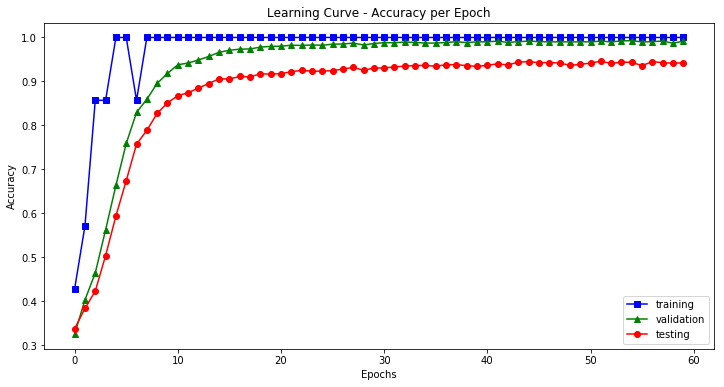

In [20]:
plt.figure(figsize=(12,6))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Accuracy per Epoch')
plt.plot(Epoch, Acc_t, 'bs-', label='training')
plt.plot(Epoch, Acc_v, 'g^-', label='validation')
plt.plot(Epoch, Acc_T, 'ro-', label='testing')
plt.legend(loc='lower right')
plt.show()

+ #### Loss

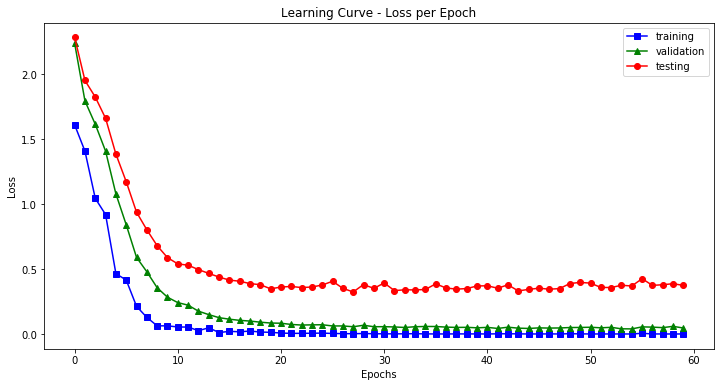

In [21]:
plt.figure(figsize=(12,6))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve - Loss per Epoch')
plt.plot(Epoch, Losst, 'bs-', label='training')
plt.plot(Epoch, Lossv, 'g^-', label='validation')
plt.plot(Epoch, LossT, 'ro-', label='testing')
plt.legend(loc='upper right')
plt.show()


### Model Validation from Learning Curve
+ #### _Validation curves converged with training curves at HIGH plateau (99.0~100.0%) in Accuracy & Very LOW (< 0.04) in LOSS. It means:_
    - ### _Model is not underfitting (low bias) as both testing and validation have reached very low errors_
    - ### _It is also not overfitting (low variance), general enough with validation; benefit from dropout at FC1_

+ #### _Testing curves not converged with training/validation curves, but it plateaued HIGH (~95%) in Accuracy & flattened LOW (< ~0.4) in LOSS_
    - ### _This means model is not overfit (on training set), it's general enough; benefit from dropout at FC1_
    - ### _Train-Test performance gap mainly due to out-of-band data (some test images not seen in training)_
    - ### _Problem is little Variance caused by images between training and testing data sets_
        - #### _Solution is have more sample data (more variants of traffic sign images given any class) feeding to the model training_
        - #### _Augment -or- add jitter images may help, but also limited considering most Sign variance isn't viewpoint transform type_
+ ### Overall performance of this model (~95.0% Accuracy & ~0.4 Loss) in final Testing is quite appealing (CPU)
+ ### Bigger model (e.g. deeper network) may help, but unnecessary at moment compare to need of more data!

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
#### Most answers lie in cells above, here is summary.
#### Following technique is used for training the model:
+ #### Used batch size = 128 (128 training samples a batch)
+ #### Trained 60 Epochs (run over all training samples in 1 epoch), Stop at Good Performance (plateaued High Accuracy, flattened Low Loss)
+ #### Used tf.train.AdamOptimizer, with initial learning rate as 0.001, this Optimizer has implemented learning rate decay internally
+ #### Hyperparamters, and tuning:
    - ##### Settled with Dropout with keep_prob = 0.5, at FC1
    - ##### Learning_rate: not explicitly tuned by taking advantage from optimizer. (to try http://cs231n.github.io/neural-networks-3/#hyper)
    - ##### Other regularization scheme e.g. L1/L2 regularization not tried as used dropout
    
#### Execute training and validation epoch-by-epoch, so be able to plot Accuracy-Epochs, Loss-Epochs learning curve to demonstrate model quality.


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

### _Finding an optimal architecture of a ConvNet for a given task remains mainly empirical, here is my approach:_

+ #### Use much visualization any time possible, it is time consuming, but very informative and easy to follow (both self and others)
+ #### Design network architecture clean, in understanding well in both network graphs and data tensors passing along
+ #### Many iteration and look forward to machine learning technique to lower the human (labor) burden doing so
+ #### Find good and reliable performance, visualize model behaviour, such as learning curve to guide tuning
+ #### Basic sanity check, find and debug errors earlier, discover obvious wrong result -or- nonesense soon!


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

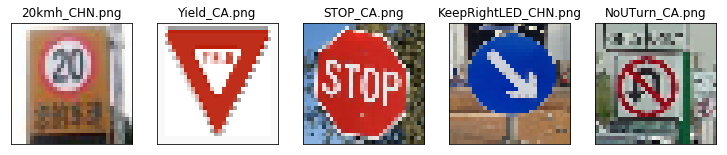

In [22]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

# Use imperfect (no smooth may lose detail) resize from cv2:
#           img = cv2.resize(img, (32, 32))

# Choose new images from various labels, and one type not yet in label space:
# 
# New Images files captured       # Projected Class ID (Human Perf.) from model's label space if ANY
newImages = ['20kmh_CHN.png',               # class 0   - very few samples in training set 
             'Yield_CA.png',                # class 13  -  lots of samples in training set
             'STOP_CA.png',                 # class 14  -  enough  samples in training set
             'KeepRightLED_CHN.png',        # class 38  -  lots of samples in training set
             'NoUTurn_CA.png']              #      None - no this sample class in training

newTruth = [0, 13, 14, 38, None]

newImgCnt = len(newImages)
newImgX = np.empty((newImgCnt, 32, 32, 3))

for i in range(newImgCnt):
    img = pimg.imread(newImages[i])
    img = cv2.resize(img, (32,32))
    newImgX[i,:,:,:] = img[:,:,0:3]

# Visualize all 5 new Traffic Sign Images to be classified
# Some loss of detail obversed
plot_gallery(newImgX, newImages, 32, 32, 1, 5)

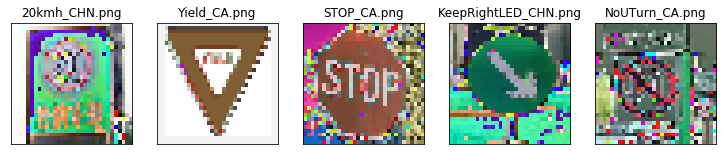

In [23]:
# Now run the same preprocessing that classifier requires on these new Images
# Same normalization as in training: (R/G/B-128.)/128 => 0 mean & normal distribution between (-1., 1.)
# X_train_norm = (X_train - 128.) / 128

# !!! but now all newImgX images are already normalized but differently in range (0., 1.) vs. (-1., 1.)
# This is due to we read them in PNG format!
# Then it is safe to do a PATCH Normalization as:

newImgX_norm = (newImgX - 0.5) * 2

plot_gallery(newImgX_norm, newImages, 32, 32, 1, 5)

#### _Plots of Normalized new Traffic Sign Images - N.B. Color scheme is correct/same as normalized training images (not shown) fed to our model_

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
Five candidate images new to the test are:
+ '20kmh_CHN.png': 20kmh Speed Limit Sign from China
+ 'Yield_CA.png': Yield Sign from California
+ 'STOP_CA.png': Stop Sign from California
+ 'KeepRightLED_CHN.png': Keep Right LED Sign from China
+ 'NoUTurn_CA.png': No U-Turn Sign from California

#### The qualities of these images (particularly after a none smooth/fine resize) are not perfect, but should be enough for a human level classifier.
+ ##### all new images are little jittering on edges (due to none smooth resize)
+ ##### that can be but not a big challenge to classifier if it is robust enough
+ ##### 20kmh Speed Limit Sign from China has got different background color with Chinese characters on it, it is interesting to see how it turns out to be from our model
+ ##### They were plotted above


The Human Truth labels of these to be classified Traffic Signs are:
[0, 13, 14, 38, None]

The Classifier Predicted labels of these new set Traffic Signs are:
[13 13 14 38 12]

13            Yield
13            Yield
14             Stop
38       Keep right
12    Priority road
Name: SignName, dtype: object


The Predicition Accuracy on these new set of Traffic Signs are: 60.00%

OK let's visualize - the new traffic signs to be classified, and then what they are classified to:


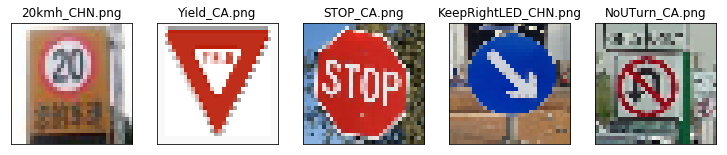

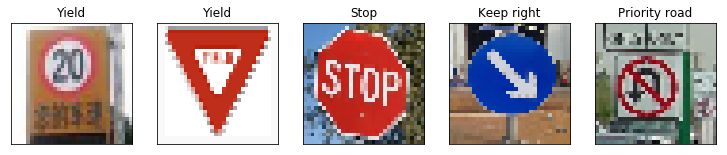

In [25]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

print("The Human Truth labels of these to be classified Traffic Signs are:\n{}\n".format(newTruth))

new_pred = np.zeros(shape = newImgCnt, dtype=np.int)
new_pred = sess.run(y_pred_class, feed_dict = {X_image: newImgX_norm, keep_prob: 1.0})
print("The Classifier Predicted labels of these new set Traffic Signs are:\n{}\n".format(new_pred))
print(sign_names['SignName'][new_pred])
print("\n")

print("The Predicition Accuracy on these new set of Traffic Signs are: {0:>6.2%}\n"
      .format((new_pred == np.array(newTruth)).sum() * 1.0 / newImgCnt))

print("OK let's visualize - the new traffic signs to be classified, and then what they are classified to:")
plot_gallery(newImgX, newImages, 32, 32, 1, 5)
plot_gallery(newImgX, list(sign_names['SignName'][new_pred]), 32, 32, 1, 5)


In [26]:
# Interestingly we have got these TWO Errors:
#                                                    Classified
# 1. 20kmh_CHN (China)      [Projected Class:  0] == wrongly to ==> [Class: 13] Yield
# 3. No U-Turn (California) [Projected Class: NA] == no  choice ==> [Class: 12] Priority road

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**
Not really. It only achieves 60.00% Accuracy on this new test set, 2/5 new samples are misclassified.
+ This 60.00% Accuracy is way lower than the performance on provided testing dataset (~95.0%), mainly because:
    - Firstly Provided testing dataset is from the same origin of given training dataset
    - Also importantly the provided testing dataset has similar sample distributions as training dataset
    - 5new test Images are from other region, 1 is in totally different formation, 1 is a new class type

#### OK since `"20kmh (China)"` is wrongly classified to `"Yield (Germany)"`, let's plot 9 random `Yield` sign from German training set been used:

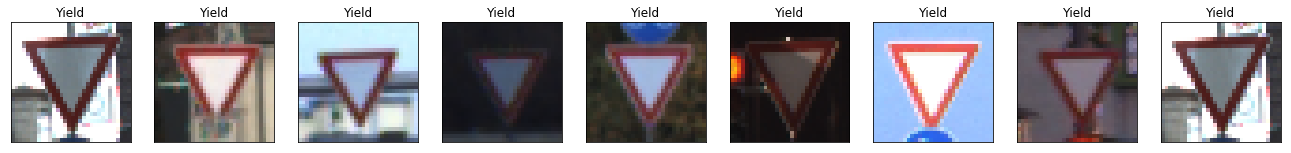

In [27]:
cls13 = np.where(y_train==13)[0]
cls13_r9 = np.random.choice(cls13, size=9, replace=False)
plot_gallery(X_train[cls13_r9], [sign_names['SignName'][13]]*9, 32, 32, 2, 9)

#### Also `"No U-Turn(California)"` is in-no-choice classified to `"Priority road"`, let's plot 9 random `target` sign in training:

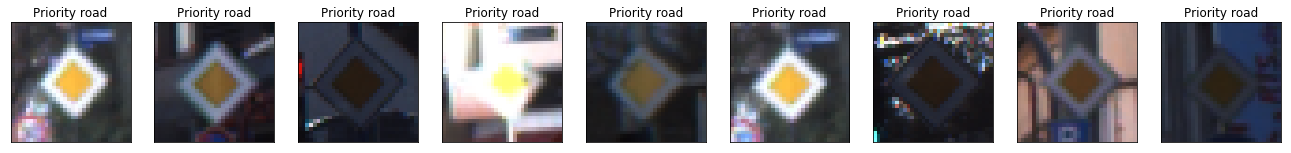

In [28]:
cls12 = np.where(y_train==12)[0]
cls12_r9 = np.random.choice(cls12, size=9, replace=False)
plot_gallery(X_train[cls12_r9], [sign_names['SignName'][12]]*9, 32, 32, 2, 9)

### From random selected wrong `target` traffic signs above, I have come to an earlier observation:
+ ####  `"20kmh(China)"` -- classified --> `"Yield(Germany)"` is totaly nonsense from visual, need an interesting insight!
    - ##### Guess is that this `"20kmh(China)"` sign has got different `Yellow` background as `German` speed limit signs
    - ##### It also has got some `Chinese` characters at the bottom, that may be countable noise
    - ##### Still not intuitive why it is classified to `Yield` vs. `others`, will do some softmax probabilities analysis next.
    - ##### But this tells us deep learning works `great` in `memorizing` seen patterns vs. potentially `poor` in never seen patterns, have more data to training is always one of the best solutions.
      
+ ####  `"No U-Turn(California)"` ---> `"Priority road"` also makes not much sense from top level image view!
    - ##### Knowing that `"No U-Turn"` is out of our model's label space (0-42), its mis-classification is expected, there is no right choice.
    - ##### This tells us `"out of label"` can contribute to big `Systematic Error` in supervised learning!
    - ##### More data and more labels (besides howto implement more labels easily) is the way to Go!
    - ##### If we need to extend this model to `"Global Traffic Sign Classifier"`, then we need to feed it with `Global Signs`.


In [29]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

# Okay let's take an error examples above to visualize its softmax probability from classification output:
#                                                    Classified
# 1. 20kmh_CHN (China)      [Projected Class:  0] == wrongly to ==> [Class: 13] Yield
# 2. No U-Turn (California) [Projected Class: NA] == no  choice ==> [Class: 19] Dangerous curve to the left

# Prediction in softmax probabilities
#  y_pred = tf.nn.softmax(logits)

top5 = tf.nn.top_k(y_pred, k=5, sorted=True, name=None)
top5_prob, top5_ind = sess.run(top5, feed_dict = {X_image: newImgX_norm, keep_prob: 1.0})

# top5_ind is the top5 Class IDs of softmax probabilities in descending order to each of these 5 new test images
print(top5_ind)


[[13  1 25 28  2]
 [13  0  1  2  3]
 [14  5 17 15  0]
 [38 36 25 33 34]
 [12 21 31 10 38]]


#### As we see `20kmh (China)` is classified as Top5 likely classes [13 1 25 28 2] in descending likelyhood, let's visualize them side-by-side!

Visualization of the mis-classifing 20kmh_CHN:
Plotted below is Top5 softmax probability Images in descending likelihood order (left is the most likely one)


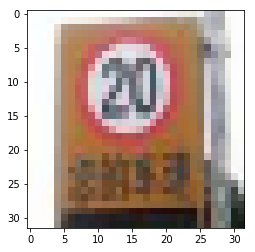

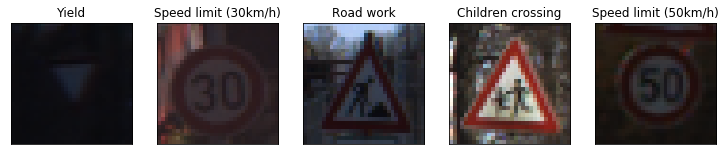

In [30]:
nImg_Indice = []
nName_Likes = []

# Build collection of likelihood Images (select random ONE from each likely Class)
for i in range(top5_ind.shape[1]):
    clsId = top5_ind[0][i]
    clsImgInd = np.where(y_train == clsId)[0]
    Img_1Like = np.random.choice(clsImgInd, size=1, replace=False)
    nImg_Indice.append(Img_1Like[0])
    like_Images = np.array(nImg_Indice)
    nName_Likes.append(sign_names['SignName'][clsId])

plt.imshow(newImgX[0])
plot_gallery(X_train[like_Images], nName_Likes, 32, 32, 1, 5)
print("Visualization of the mis-classifing 20kmh_CHN:")
print("Plotted below is Top5 softmax probability Images in descending likelihood order (left is the most likely one)")


### According to softmax probability (see cell below), 20kmh (China) Sign is considered as following signs in order:
+ #### `"Yield"` with Probability 9.99866486e-01 (dominant)
+ #### `"Speed limit (30km/h)"` with Probability 1.02254424e-04
+ #### `"Road work"` with Probability 2.11055212e-05
+ #### `"Children crossing"` with Probability 8.36047275e-06
+ #### `"Speed limit (50km/h)"` with Probability 8.39090092e-07

#### It is hard to see exact why `"Yield"` is thought to be the closest one, but we notice that they all seem to have `Yellow` color around the `Red` border and `White` color area inside, in common to the top center part of `20kmh_CHN` sign.

#### As we see `No U-Turn (CAL)` is classified as Top5 likely classes [12 21 31 10 38] in descending likelyhood, let's visualize them side-by-side!

Visualization of the mis-classifing No U-Turn_CA:
Plotted below is Top5 softmax probability Images in descending likelihood order (left is the most likely one)


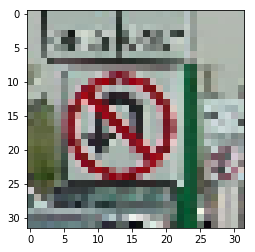

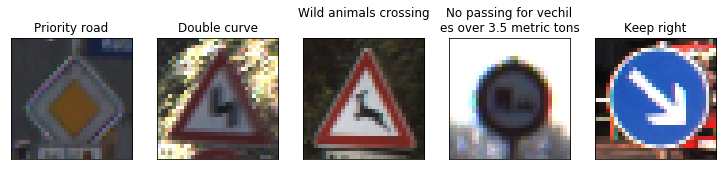

In [31]:
nImg_Indice = []
nName_Likes = []

# Build collection of likelihood Images (select random ONE from each likely Class)
for i in range(top5_ind.shape[1]):
    clsId = top5_ind[4][i]
    clsImgInd = np.where(y_train == clsId)[0]
    Img_1Like = np.random.choice(clsImgInd, size=1, replace=False)
    nImg_Indice.append(Img_1Like[0])
    like_Images = np.array(nImg_Indice)
    nName_Likes.append(sign_names['SignName'][clsId])

plt.imshow(newImgX[4])
plot_gallery(X_train[like_Images], nName_Likes, 32, 32, 1, 5)
print("Visualization of the mis-classifing No U-Turn_CA:")
print("Plotted below is Top5 softmax probability Images in descending likelihood order (left is the most likely one)")


### According to softmax probability (see cell below), No U-Turn (California) Sign is thought as these signs in order:
+ #### `"Priority road"` with Probability 7.17815220e-01
+ #### `"Double curve"` with Probability 2.64922172e-01
+ #### `"Wild animals crossing"` with Probability 8.38514604e-03
+ #### `"No passing for vechiles over 3.5 metric tons"` with Probability 5.94464038e-03
+ #### `"Keep right"` with Probability 2.93217343e-03

#### It is little easier to see why `Double curve` or `Wild animals crossing` are thought to be close ones, due to the common `left turning half` black mark exists in the center. This pattern of `Red border` around `White inner` area with certain `Black curvly shape` in the center is common in 3 of the top5 candidates. `Keep right` can be similar in an outlier circle with an inner crossing line, except for the different color map.


In [32]:
# Top5 probabilities of 5 new samples.
print(top5_prob)

[[  9.99866486e-01   1.02254424e-04   2.11055212e-05   8.36047275e-06
    8.39090092e-07]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.00000000e+00   2.49593892e-08   1.09208943e-15   9.90183633e-16
    3.11182658e-19]
 [  8.82146776e-01   1.17853232e-01   1.38648388e-22   9.14163448e-26
    9.86482695e-28]
 [  7.17815220e-01   2.64922172e-01   8.38514604e-03   5.94464038e-03
    2.93217343e-03]]


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

+ Most answers lie in sections above
+ Out of 5 predictions (over 5 new Images), model is very certain on all three correctly classified ones (Yield_CA, STOP_CA, KeepRightLED_CHN) in that their top class prediction probabilities are all almost 1.0
+ To the TWO wrongly classified ones, model is still very certain of its top class predictions in dominant 94.68~99.99% probabilities
+ And unfortunately (to the 2 misclassified Images) a correct prediction does NOT appear to be in the top 5, and the out-of-label (No U-Turn) one would never have a correct prediction in any existing class


In [33]:
# close tf.Session object. It is commented out to avoid accidental close(), which will lose
# training model prior to a checkpoint save(training) / restore(predict) being put in place
# sess.close()


### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

+ For the simplicity I have not closed my TensorFlow session from training (STOP), so all the tuned Variables, model parameters and model itself are just used as it is. Main add-on interfaces are:
    - use matplotlib to load 5 PNG images (to np.array, care is taken only the first 3 color channels being compatible with training image channels)
    - use cv2.resize to down-sample new images to the same size of 32x32, in shape of (32, 32, 3)
    - run a same effect preprocessing (normalization) on this new set of Images 
    - run session evauation on y_pred_class with feeding these new images to get prediction class
    - run session evalution on tf.nn.top_k of y_pred (softmax probability) object to get most probable 5 classes of an Image 
+ As an extension to this project, models save and restore using checkpoint, or Metagraph's export and import will be implemented later, with benefit of flexible session management and models sharing cross sessions, machines or platform
+ As a candidate to a real product, I can build interface to have this train a model, then export model (with protobuf) to embedded device (Andriod, IOS), so we have a live capture-&-classify applications on traffic signs


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.